In [1]:
from lognormal_counts_yunting import *

In [2]:
ng_bins=1 # this is the number of redshift bins you want, if you want to generate several GRFs and superpose them
zmin=0.01
zmax=1.0
n_catalog = 1
number_counts = [5000] # you want this to be in counts per square degree, since it gets multiplied by n_square_deg 
                        # in the function below. you might get a values from the helgason model

ell_min = 90
Npix = 1024
deg_pix = 2/Npix

upscale = 4
size = Npix*upscale # side length of image to place counts in 
n_square_deg = (2*upscale)**2

In [3]:
# generate the clustering catalog. check the defaults to 
#make sure they are what you want, especially with ell_min and the like.
tx, ty, grfs = generate_galaxy_clustering(number_counts, size=size, 
                                    ell_min=ell_min/upscale, n_square_deg=n_square_deg, 
                                    n_catalog=n_catalog, ng_bins=ng_bins, return_grf=True)

cat = np.array([tx[0], ty[0]]).transpose()
gmap_unnormalized = make_galaxy_cts_map(cat, [size, size], normalize=False)

/Users/ytcheng/ciber/python_ciber/stack_modelfit/lognormal_counts_yunting.py:66: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))


In [4]:
from clustering import *

ra = (np.array(tx[0]) - (Npix*upscale-1)/2) * deg_pix
dec = (np.array(ty[0]) - (Npix*upscale-1)/2) * deg_pix

ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                             (min(dec), max(dec)),
                             2 * len(ra))

D_idx = np.where((ra > -1) & (ra < 1) & (dec > -1) & (dec < 1))[0]
R_idx = np.where((ra_R > -1) & (ra_R < 1) & (dec_R > -1) & (dec_R < 1))[0]

theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])

corr, corr_in, corr_err, corr_err_in, bootstraps\
= bootsrap_two_point_angular_window([ra, dec], [ra_R, dec_R],
                                                    theta_binedges_deg, D_idx, R_idx,Nbootstrap=3)

corr_in_only, corr_in_only_err, _ = get_angular_2pt_func\
                (ra[D_idx], dec[D_idx], theta_binedges_deg, nboot=3)

corr_subs = []
for ra_min, ra_max in zip(np.arange(-4,4,2), np.arange(-4,4,2)+2):
        for dec_min, dec_max in zip(np.arange(-4,4,2), np.arange(-4,4,2)+2):
            sp = np.where((ra > ra_min) & (ra < ra_max) & (dec > dec_min) & (dec < dec_max))[0]
            corr_sub = get_angular_2pt_func\
                            (ra[sp], dec[sp], theta_binedges_deg, nboot=1)
            corr_subs.append(corr_sub)

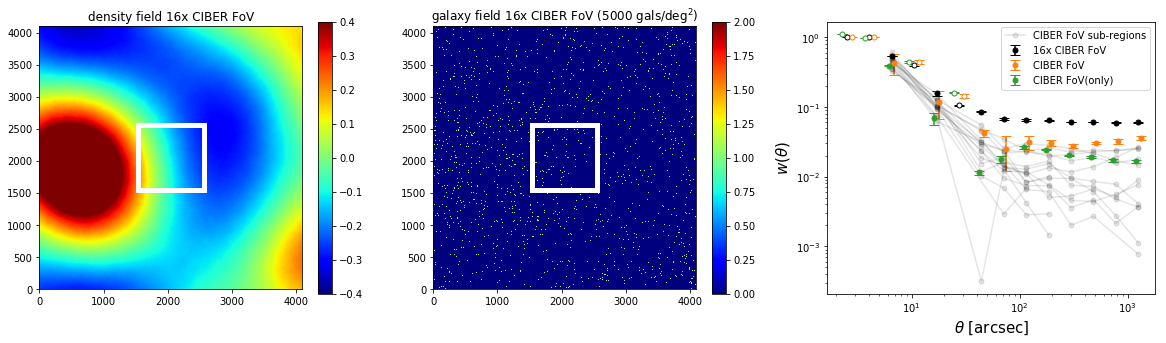

In [7]:
from utils_plotting import *
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,3, figsize=(20,5))
imageclip(grfs[0][0], vmin=-0.4, vmax=0.4, ax=ax[0])
imageclip(gmap_unnormalized, vmin=0, vmax=2, ax=ax[1])
ax[0].add_patch(Rectangle((1024*1.5,1024*1.5), 1024, 1024, fill=None, alpha=1,lw=5,color='w'))
ax[1].add_patch(Rectangle((1024*1.5,1024*1.5), 1024, 1024, fill=None, alpha=1,lw=5,color='w'))
ax[0].set_title('density field 16x CIBER FoV')
ax[1].set_title('galaxy field 16x CIBER FoV (%d gals/deg$^2$)'%number_counts[0])

ax[2].errorbar(theta_bins, corr, corr_err, 
             fmt='.', color='k',capsize=5, markersize=10, label='16x CIBER FoV')
ax[2].errorbar(theta_bins, -corr, corr_err, 
             fmt='.', mfc='white', color='k',capsize=5, markersize=10)
for i in range(len(corr_subs)):
    sp = np.where(corr_subs[i]>0)[0]
    if i==0:
        ax[2].loglog(theta_bins[sp], corr_subs[i][sp], '.-', color='k',
                     markersize=10, alpha=0.1, label='CIBER FoV sub-regions')
    else:
        ax[2].loglog(theta_bins[sp], corr_subs[i][sp], '.-', color='k',
                     markersize=10, alpha=0.1)
        
ax[2].errorbar(theta_bins*1.05, corr_in, corr_err_in, 
             fmt='.', color='C1',capsize=5, markersize=10,label='CIBER FoV')
ax[2].errorbar(theta_bins[corr_in<0]*1.1, -corr_in[corr_in<0], corr_err_in[corr_in<0], 
             fmt='.', mfc='white', color='C1',capsize=5, markersize=10)
ax[2].errorbar(theta_bins*0.95, corr_in_only, 
             corr_err, fmt='.', color='C2',capsize=5, markersize=10,label='CIBER FoV(only)')
ax[2].errorbar(theta_bins[corr_in_only<0]*0.9, -corr_in_only[corr_in_only<0], 
             corr_err[corr_in_only<0], fmt='.', mfc='white', color='C2',capsize=5, markersize=10)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax[2].set_ylabel(r'$w(\theta)$', fontsize=15)
ax[2].legend()

plt.savefig('/Users/ytcheng/Desktop/window_test', dpi = 200, bbox_inches='tight')

# Calculate the window from theory
calculate frac of area out of field for each radial bin

In [23]:
from utils import *

theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])

f_arr = []
for ibin in range(len(theta_bins)):
    Npix_expected = np.pi*(theta_binedges_arcsec[ibin+1]**2 \
                           - theta_binedges_arcsec[ibin]**2)/7**2
    Ntot, Nin = 0, 0
    for x in np.arange(0,1024,25):
        for y in np.arange(0,1024,25):
            radmap = radmap = make_radius_map(np.zeros([1024,1024]), x, y)*7
            sp = np.where((radmap>theta_binedges_arcsec[ibin]) & \
                         (radmap<theta_binedges_arcsec[ibin+1]))
            Ntot += Npix_expected
            Nin += len(sp[0])
            
    f_arr.append(Nin / Ntot)

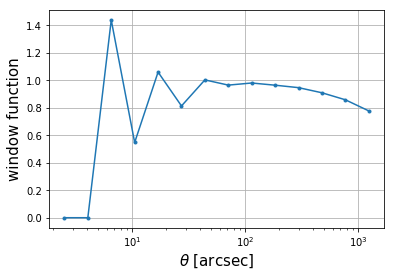

In [26]:
plt.semilogx(theta_bins,f_arr,'.-')
plt.xlabel(r'$\theta$ [arcsec]', fontsize=15)
plt.ylabel('window function', fontsize=15)
plt.grid()
plt.savefig('/Users/ytcheng/Desktop/window_theory', dpi = 200, bbox_inches='tight')

In [5]:
from lognormal_counts_yunting import *
from clustering import *
import time

def run_window_sim(run_label, n_catalog=30, zmin=0.01, zmax=1.0, counts_per_sqdeg=5000):
    
    # this is the number of redshift bins you want,
    #if you want to generate several GRFs and superpose them
    ng_bins = 1
    
    ell_min = 90
    Npix = 1024
    deg_pix = 2/Npix

    upscale = 4
    size = Npix*upscale # side length of image to place counts in 
    n_square_deg = (2*upscale)**2

    theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
    theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
    theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])

    corrs = []
    corr_ins = []
    corr_in_onlys = []

    start_time = time.time()
    
    for icat in range(n_catalog):
        elapse_time = (time.time()-start_time)/60
        print('generating %d/%d catalogs from correlated GRF (%.2f min)'%(icat,n_catalog, elapse_time))
        tx, ty = generate_galaxy_clustering([counts_per_sqdeg], size=size, 
                                            ell_min=ell_min/upscale, n_square_deg=n_square_deg, 
                                            n_catalog=n_catalog, ng_bins=ng_bins)

        ra = (np.array(tx[0]) - (Npix*upscale-1)/2) * deg_pix
        dec = (np.array(ty[0]) - (Npix*upscale-1)/2) * deg_pix

        ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                     (min(dec), max(dec)),
                                     2 * len(ra))

        D_idx = np.where((ra > -1) & (ra < 1) & (dec > -1) & (dec < 1))[0]
        R_idx = np.where((ra_R > -1) & (ra_R < 1) & (dec_R > -1) & (dec_R < 1))[0]


        corr, corr_in = bootsrap_two_point_angular_window([ra, dec], [ra_R, dec_R],
                                                            theta_binedges_deg, D_idx, R_idx)

        corr_in_only = get_angular_2pt_func\
                        (ra[D_idx], dec[D_idx], theta_binedges_deg, nboot=1)

        corrs.append(corr)
        corr_ins.append(corr_in)
        corr_in_onlys.append(corr_in_only)
   
    corrs = np.array(corrs)
    corr_ins = np.array(corr_ins)
    corr_in_onlys = np.array(corr_in_onlys)
    
    data = np.stack((corrs, corr_ins, corr_in_onlys))
    
    np.save('./wfunc_data/wfunc_sim_run_%d'%(run_label),data)
    
    return data

In [6]:
data = run_window_sim(0, n_catalog=4, counts_per_sqdeg=50)

generating 4 catalogs from correlated GRF


/Users/ytcheng/ciber/python_ciber/stack_modelfit/lognormal_counts_yunting.py:66: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))


generating 4 catalogs from correlated GRF


/Users/ytcheng/ciber/python_ciber/stack_modelfit/lognormal_counts_yunting.py:66: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))


generating 4 catalogs from correlated GRF


/Users/ytcheng/ciber/python_ciber/stack_modelfit/lognormal_counts_yunting.py:66: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))


generating 4 catalogs from correlated GRF


/Users/ytcheng/ciber/python_ciber/stack_modelfit/lognormal_counts_yunting.py:66: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))


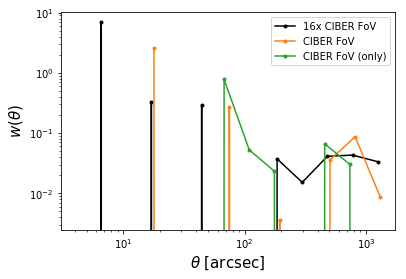

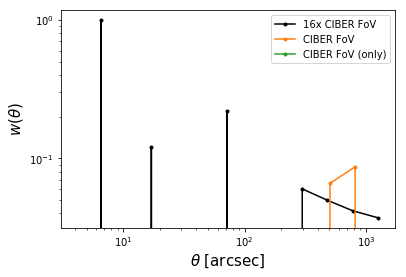

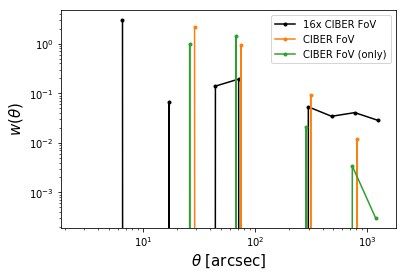

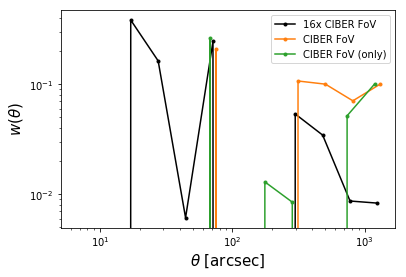

In [7]:
data = np.load('./wfunc_data/wfunc_sim_run_%d.npy'%(0))

theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])

for i in range(data.shape[1]):
    fig,ax = plt.subplots(1,1)
    
    corrs, corr_ins, corr_in_onlys = data[0,i,:], data[1,i,:], data[2,i,:]
    ax.loglog(theta_bins, corrs, 'k.-', label='16x CIBER FoV')
    ax.loglog(theta_bins*1.05, corr_ins, 'C1.-', label='CIBER FoV')
    ax.loglog(theta_bins*0.95, corr_in_onlys, 'C2.-', label='CIBER FoV (only)')
    
    ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
    ax.set_ylabel(r'$w(\theta)$', fontsize=15)
    ax.legend()